In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer


In [13]:

def model(X, y, smote=True):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=11)
    
    if smote == True:
        pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                        ['scaler', MinMaxScaler()],
                                        ['classifier', LogisticRegression(random_state=11,
                                                                          max_iter=1000)]])
    else:
        smote = SMOTE(random_state = 11)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],
                                     ['classifier', LogisticRegression(random_state=11,
                                                                       max_iter=1000)]])
        
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
    
    param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)
    
    
    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    return {'cv_score':cv_score, 'test_score':test_score}

In [17]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


main_df_list = []

for i in range(50):
    np.random.seed(i)
    
    N_SAMPLES = np.random.randint(low=10000, high=50000, size=1)[0]
    N_FEATURES = np.random.randint(low=20, high=40, size=1)[0]
    N_INFORMATIVE = N_FEATURES - np.random.randint(low=2, high=5, size=1)[0]
    CLASS_SEP = np.random.uniform(low=0.4, high=0.8, size=1)[0]
    MINORITY_CLASS_WEIGHT = np.random.uniform(low=0.05, high=0.3, size=1)[0]

    # 0.2 minority class and 0.8 majority class

    CLASS_WEIGHTS = {1: MINORITY_CLASS_WEIGHT, 0: (1 - MINORITY_CLASS_WEIGHT)}

    data = make_classification(n_samples=N_SAMPLES,
                               n_features=N_FEATURES,
                               n_informative=N_INFORMATIVE,
                               n_redundant=0,
                               class_sep=CLASS_SEP,
                               weights=CLASS_WEIGHTS,
                               random_state=11)
    
    X = data[0].copy()
    y = data[1].copy()

    print("X",X,X.shape)
    print("Y",y,y.shape)

    
    model_smote_in_pipeline = model(X, y, smote=True)
    model_smote_out_pipeline = model(X, y, smote=False)
    
    df = pd.DataFrame({'N_SAMPLES': N_SAMPLES,
                       'N_FEATURES': N_FEATURES,
                       'N_INFORMATIVE': N_INFORMATIVE,
                       'CLASS_SEP': CLASS_SEP,
                       'MINORITY_CLASS_WEIGHT': MINORITY_CLASS_WEIGHT,
                       'SMOTE_IN_PIPELINE_CV_SCORE': model_smote_in_pipeline['cv_score'],
                       'SMOTE_IN_PIPELINE_TEST_SCORE': model_smote_in_pipeline['test_score'],
                       'SMOTE_OUTSIDE_PIPELINE_CV_SCORE': model_smote_out_pipeline['cv_score'],
                       'SMOTE_OUTSIDE_PIPELINE_TEST_SCORE': model_smote_out_pipeline['test_score']},
                      index=[i])
    
    main_df_list.append(df)
    print(i)

main_df = pd.concat(main_df_list, ignore_index=True)


X [[ 5.18433666 -5.10714041 -3.30052272 ... -3.15292972 -0.15190883
   3.08526886]
 [-0.93213801  1.32534613  1.14945356 ... -1.73759966 -3.29003919
   3.53661936]
 [ 1.22651439  2.16613147 -6.78539127 ... -0.7268659  -4.4588965
  -6.4004014 ]
 ...
 [-1.96389889 -1.95744651 -4.41748925 ... -3.94408639  6.66989047
  -0.80095431]
 [-0.1844934  -2.61135437 -2.82624175 ...  1.42312607  8.20064566
   4.1224237 ]
 [ 0.57356156  2.53028693  6.35902691 ... -2.45575417 -1.03275227
   0.08552808]] (12732, 35)
Y [1 0 0 ... 1 0 1] (12732,)
0
X [[-6.74650384 -1.57386123 -2.73694532 ...  4.08821451  2.81168593
  -0.69425282]
 [-1.26081753  1.60210214  3.64468109 ... -1.15352844  1.69148214
   3.98924293]
 [-0.59190517 -0.10866519 -0.62584722 ...  3.44889794 -5.89317015
  -1.73079131]
 ...
 [-0.51641827 -3.53338324 -1.77221946 ... -0.36120568 -0.59724704
  -2.35760906]
 [ 1.35953326  1.93322113 -3.65369198 ...  0.20330549  6.01337677
   6.37950353]
 [ 2.23145545 -6.35298819  3.0015928  ...  2.1184381

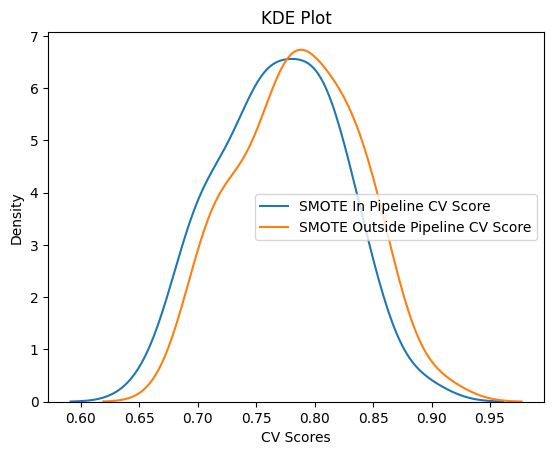

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=main_df["SMOTE_IN_PIPELINE_CV_SCORE"], label='SMOTE In Pipeline CV Score')
sns.kdeplot(data=main_df['SMOTE_OUTSIDE_PIPELINE_CV_SCORE'], label='SMOTE Outside Pipeline CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()


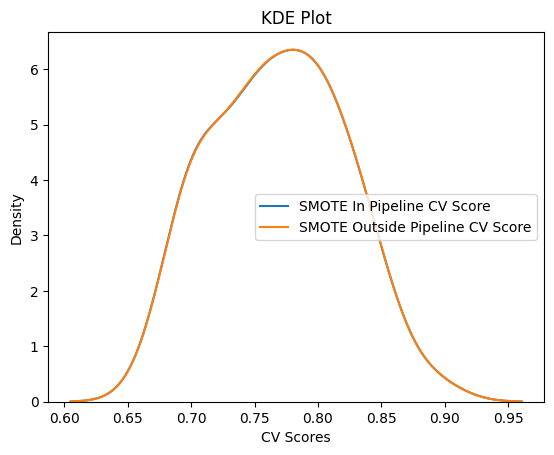

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=main_df["SMOTE_IN_PIPELINE_TEST_SCORE"], label='SMOTE In Pipeline CV Score')
sns.kdeplot(data=main_df['SMOTE_OUTSIDE_PIPELINE_TEST_SCORE'], label='SMOTE Outside Pipeline CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()


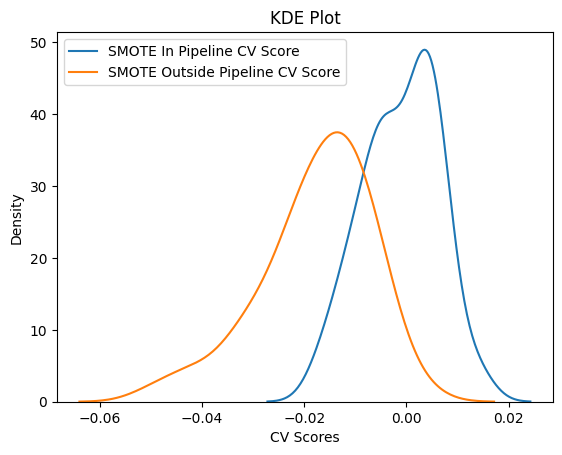

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=(main_df["SMOTE_IN_PIPELINE_TEST_SCORE"]-main_df["SMOTE_IN_PIPELINE_CV_SCORE"]), label='SMOTE In Pipeline CV Score')
sns.kdeplot(data=(main_df["SMOTE_OUTSIDE_PIPELINE_TEST_SCORE"]-main_df["SMOTE_OUTSIDE_PIPELINE_CV_SCORE"]), label='SMOTE Outside Pipeline CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()

In [ ]:
# We can see that the percentage difference in the cross-validation and test scores when SMOTE is included in the pipeline (‘SMOTE_IN_PIPELINE_PERCENT_DIFF’) is low when compared to the ones where SMOTE is outside the pipeline (‘SMOTE_OUTSIDE_PIPELINE_PERCENT_DIFF’). Now we’ll remove the outliers.

In [31]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        
    def outlier_removal(self, X, y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (self.factor * iqr)
        upper_bound = q3 + (self.factor * iqr)
        X.loc[((X < lower_bound) | (X > upper_bound))] = np.nan 
        return pd.Series(X)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.outlier_removal)
    
# Create an instance of the OutlierRemover class
outlier_remover = OutlierRemover()

# Select the last two columns of the DataFrame main_df
percent_diff = main_df.iloc[:, -2:].copy()

# Apply the outlier removal transformation to the selected columns
percent_diff = outlier_remover.fit_transform(percent_diff).copy()


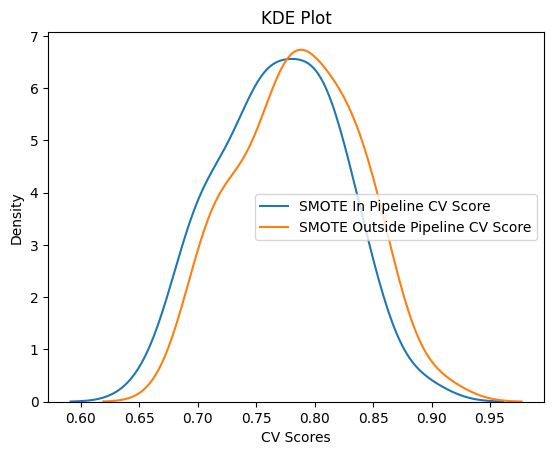

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=main_df["SMOTE_IN_PIPELINE_CV_SCORE"], label='SMOTE In Pipeline CV Score')
sns.kdeplot(data=main_df['SMOTE_OUTSIDE_PIPELINE_CV_SCORE'], label='SMOTE Outside Pipeline CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()


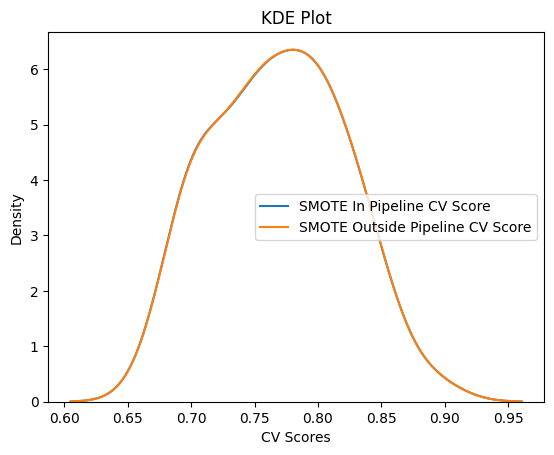

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=main_df["SMOTE_IN_PIPELINE_TEST_SCORE"], label='SMOTE In Pipeline CV Score')
sns.kdeplot(data=main_df['SMOTE_OUTSIDE_PIPELINE_TEST_SCORE'], label='SMOTE Outside Pipeline CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()


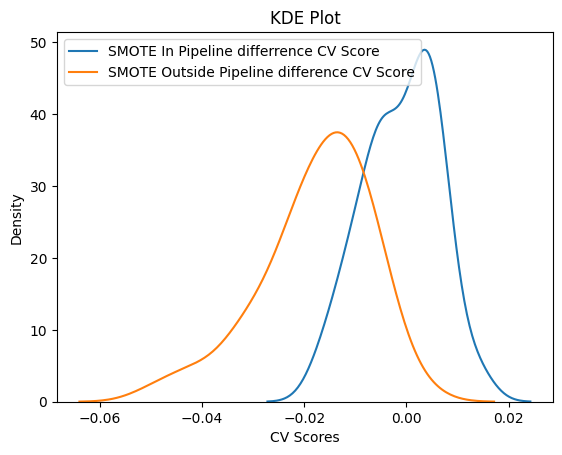

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=(main_df["SMOTE_IN_PIPELINE_TEST_SCORE"]-main_df["SMOTE_IN_PIPELINE_CV_SCORE"]), label='SMOTE In Pipeline differrence CV Score')
sns.kdeplot(data=(main_df["SMOTE_OUTSIDE_PIPELINE_TEST_SCORE"]-main_df["SMOTE_OUTSIDE_PIPELINE_CV_SCORE"]), label='SMOTE Outside Pipeline difference CV Score')

plt.xlabel('CV Scores')
plt.ylabel('Density')
plt.title('KDE Plot')

plt.legend()

plt.show()

In [36]:
def confidence_interval(x):
    x = x.dropna().copy()
    mean = x.mean()
    n = len(x)
    std = x.std()
    return (mean - (1.96 * (std / np.sqrt(n))),
            mean + (1.96 * (std / np.sqrt(n))))

print(f'confidence interval of mean SMOTE_IN_PIPELINE_PERCENT_DIFF: {confidence_interval((main_df["SMOTE_IN_PIPELINE_TEST_SCORE"]-main_df["SMOTE_IN_PIPELINE_CV_SCORE"]))}\n' +
f'confidence interval of mean SMOTE_OUTSIDE_PIPELINE_PERCENT_DIFF: {confidence_interval((main_df["SMOTE_OUTSIDE_PIPELINE_TEST_SCORE"]-main_df["SMOTE_OUTSIDE_PIPELINE_CV_SCORE"]))}\n')

confidence interval of mean SMOTE_IN_PIPELINE_PERCENT_DIFF: (-0.0030807359914061657, 0.0009640871242843259)
confidence interval of mean SMOTE_OUTSIDE_PIPELINE_PERCENT_DIFF: (-0.020744326349199795, -0.014737901087310837)



In [ ]:
# hence we can conclude that we must used smote inside pipeline instead of outside pipeline 
#  This shows that including SMOTE in the pipeline results in a more accurate cross-validation score. 
# This experiment shows that the observations from the breast cancer dataset are just by chance

# The correlation coefficient between ‘MINORITY_CLASS_WEIGHT’ and ‘SMOTE_OUTSIDE_PIPELINE_PERCENT_DIFF’ is found to be -0.45, while that of ‘MINORITY_CLASS_WEIGHT’ and ‘SMOTE_IN_PIPELINE_PERCENT_DIFF’ is -0.2.
# This shows that as the size of minority class decreases, the percentage difference between the cross-validation and test score when SMOTE is outside the pipeline increases